# Tansformations in PyTorch

## 0. Import modules and images

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import torchvision.transforms.functional as TF

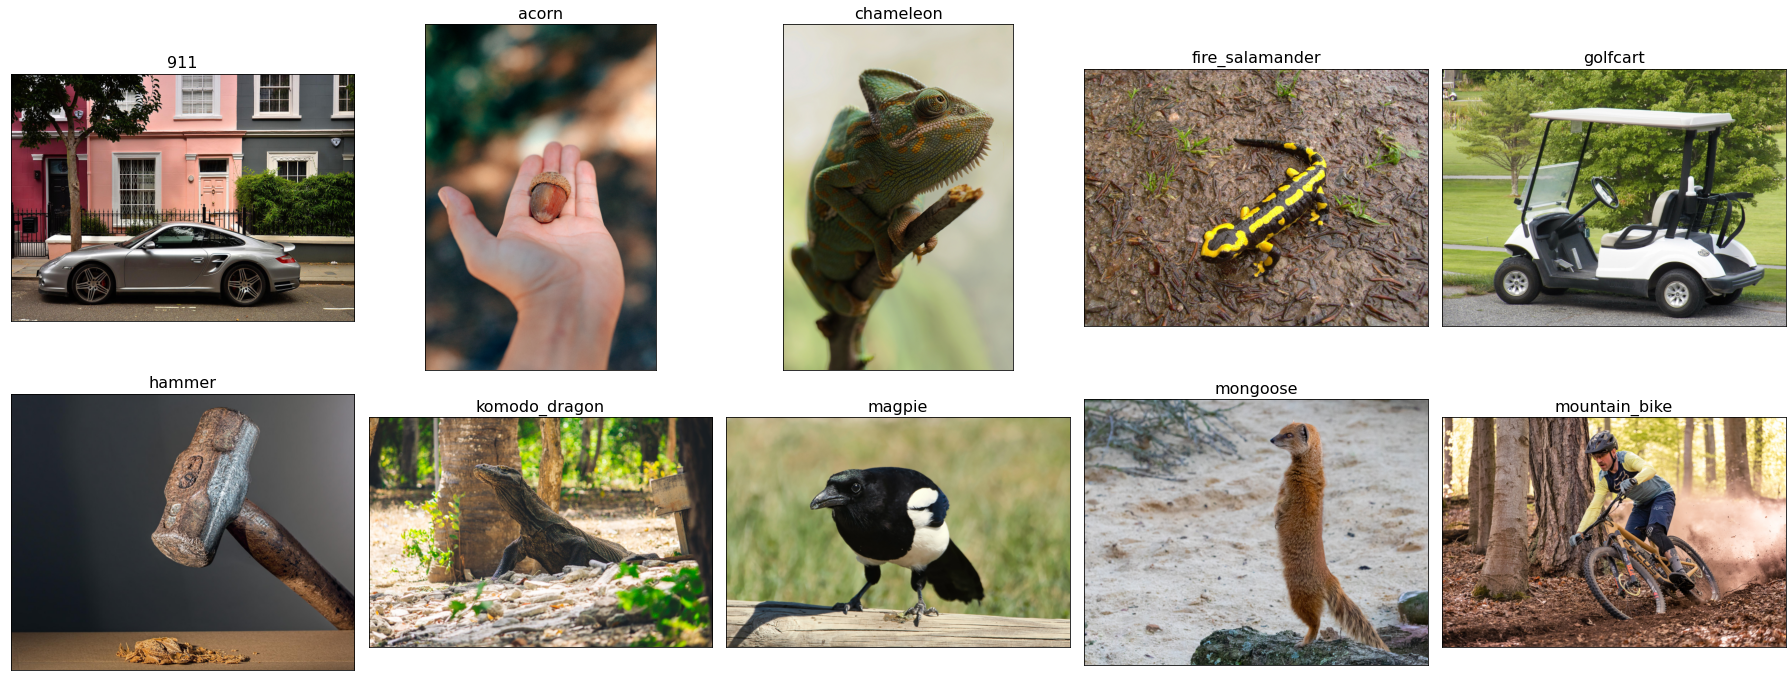

In [2]:
from pathlib import Path
import PIL
from PIL import Image
import numpy as np

# Get example images
# Images are from unsplash.com, pexels.com, or pixabay.com and free to use
image_paths = sorted([x for x in Path('data/feature-maps').glob("*.jpg")])
images = {k.stem:v for k, v in zip(image_paths, image_paths)}
images.keys()

# Show example images with helper function
from img_utils import show_images
show_images(list(images.values()), titles=list(images.keys()), per_row=5, imsize=(5, 5), crop=False, resize=500);

# Helper function, apply torch transforms to image
def apply_transforms(image_path:str, transform):
    img = Image.open(image_path)  # open image
    img = transform(img)  # apply transforms
    img = torch.unsqueeze(img, 0)  # set batch size 1 and send to device
    return img

## 1. Custom image kernels

### Apply kernel on image unsing PyTorchs convolution

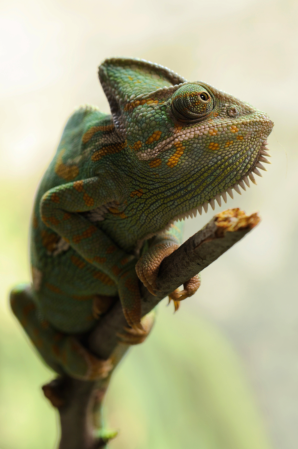

In [3]:
def apply_kernel(img, kernel=torch.tensor([[0., 0., 0.],[0., 1., 0.],[0., 0., 0.]]), channel=None, transform=None, intensity:float=None):
    """Apply kernel to image.
    
    args:
        img: pil image
        kernel: torch tensor, shape height x widht
        channels: apply on single channel int: 0, 1, 2 or to all channels
        transform: apply other PIL torch.transforms beforehand
        intensity: float; especially for edge detection: set threshold for better display
    """
    if transform:
        # Apply resize and similar PIL operations before transforming ToTensor!
        img = transform(img)
    img = transforms.ToTensor()(img).unsqueeze(0)  # shape is batch_size (1) x color channels (RGB) x height x width
    num_channels = img.shape[1]
    if channel in range(num_channels):
        num_channels = 1
        img = img[0][channel].unsqueeze(0)
    weights = kernel.repeat(num_channels, 1, 1, 1)
    convolution = F.conv2d(img, weights, groups=num_channels)
    output = convolution.squeeze(0) / torch.max(convolution)  # normalize for display
    if intensity:
        output *= intensity
        
    return transforms.ToPILImage()(output)

k_identity = torch.tensor([
    [0., 0., 0.],
    [0., 1., 0.],
    [0., 0., 0.]]
)

# Applying identity, the output should look like the original image
apply_kernel(Image.open(images['chameleon']), k_identity, transform=transforms.Resize(300))

### Example kernels

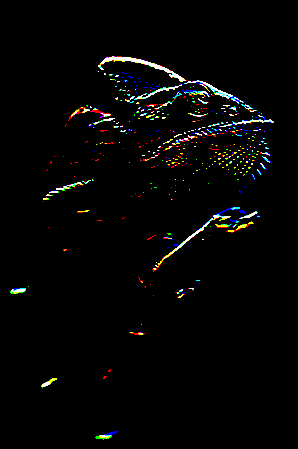

In [4]:
img = Image.open(images['chameleon'])

k_id = torch.tensor([
    [0., 0., 0.],
    [0., 1., 0.],
    [0., 0., 0.]]
)

k_sharpen = k_id + 0.3 * torch.tensor([[0., -1., 0.],[-1., 4., -1.],[0., -1., 0.]])
k_blur = (1/9)*torch.tensor([[1., 1., 1.],[1., 1., 1.],[1., 1., 1.]])
k_ridge_detection = 8 * k_id + torch.tensor([[-1., -1., -1.],[-1., 1., -1.],[-1., -1., -1.]])
k_sobel_x = torch.tensor([[-1., 0., 1.],[-2., 0., 2.],[-1., 0., 1.]])
k_sobel_y = torch.tensor([[-1., -2., -1.],[0., 0., 0.],[1., 2., 1.]])
k_scharr_x = torch.tensor([[-47., 0., 47.],[-162., 0., 162.],[-47., 0., 47.]])
k_scharr_y = torch.tensor([[-47., -162., -47.],[0., 0., 0.],[47., 162., 47.]])
k_gaussian_blur = (1/16)*torch.tensor([[1., 2., 1.],[2., 4., 2.],[1., 2., 1.]])
k_gaussian_unsharp = (-1/256)*torch.tensor([[1., 4., 6., 4., 1.],[4., 16., 24., 16., 4.],[6., 24., 36., 24., 4.],[6., 24., -476., 24., 6.],[1., 4., 6., 4., 1.]])

# From trochvision native https://pytorch.org/vision/stable/transforms.html
gaussian_blur = transforms.GaussianBlur(15, sigma=(0.1, 2.0))
# gaussian_blur(transforms.Resize(300)(img))


apply_kernel(img, k_sobel_y, transform=transforms.Resize(300), channel=3, intensity=0.02)

### 2D, discrete convolution on a tensor

In [5]:
tensor = torch.tensor([[0,0,0,0,0], [0,1,1,0,1], [0,0,1,2,1], [0,1,1,2,0], [0,2,2,0,0]], dtype=torch.float32)
num_channels = 1
kernel = k_sobel_y
weights = kernel.repeat(num_channels, 1, 1, 1)
convolution = F.conv2d(tensor.unsqueeze(0), weights, groups=num_channels)

convolution

[W NNPACK.cpp:53] Could not initialize NNPACK! Reason: Unsupported hardware.


tensor([[[ 1.,  4.,  6.],
         [ 0.,  2.,  3.],
         [ 5.,  2., -4.]]])

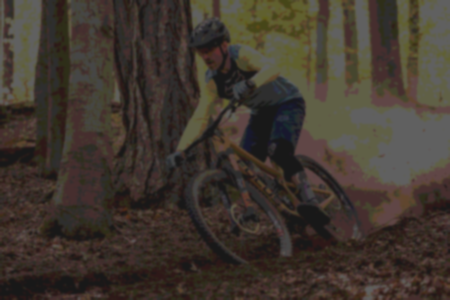

In [7]:
img = Image.open(images['mountain_bike'])

to_tensor = transforms.ToTensor()
to_pil = transforms.ToPILImage()
normalize = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
unnormalize = transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], std=[1/0.229, 1/0.224, 1/0.225])

# for randomness, use T.RandomApply

def custom_transform(image: PIL.Image.Image) -> PIL.Image.Image:
    image = TF.posterize(image, 2)
    image = TF.adjust_brightness(image, 0.8)
    image = TF.adjust_contrast(image, 0.5)
    image = TF.adjust_gamma(image, 1.2)
    image = TF.gaussian_blur(image, 11, 1)
    return image

def overlay(image: PIL.Image.Image) -> PIL.Image.Image:
    print(TF.get_dimensions(image))
    background = image#.convert("RGBA")
    overlay = image#.convert("RGBA")
    overlay = Image.open(images['chameleon'])
    overlay = TF.resize(overlay, TF.get_dimensions(image)[1:])
    image = Image.blend(background, overlay, 0.5)
    
    
    return image


transform = transforms.Compose([
    # transforms.ToTensor(),
    transforms.Resize(300),
    transforms.Lambda(custom_transform),
])


test = transform(img)
test

### noise 
https://github.com/caseman/noise

https://gist.github.com/vadimkantorov/ac1b097753f217c5c11bc2ff396e0a57

https://github.com/pvigier/perlin-numpy/